In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<br><br>
<font size='6'><b>Deep Learning Practice</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        by Seungtae Park and Suhyun Kim<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

In [1]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# 1. Data Load

- cPickle을 이용하여 데이터 로드

In [2]:
from six.moves import cPickle

In [3]:
data = cPickle.load(open('./data_files/rotation_data.pkl', 'rb'))

- Data 구조 파악 (Dictionary로 저장해둔 데이터)

In [4]:
print(data.keys())

dict_keys(['normal', 'unbal', 'rubbing', 'misalign'])


In [5]:
(X1, y1) = data['misalign']
(X2, y2) = data['unbal']
(X3, y3) = data['normal']
(X4, y4) = data['rubbing']

- Plot 으로 확인하기

In [6]:
import matplotlib.pyplot as plt

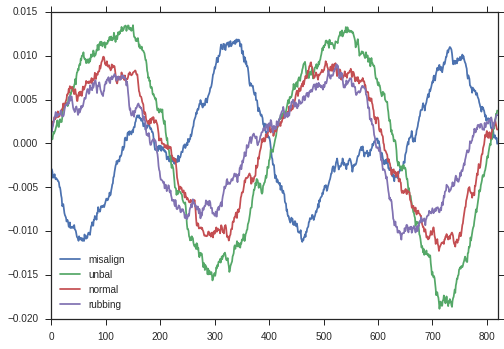

In [8]:
for data_type in ['misalign', 'unbal', 'normal', 'rubbing']:
    X, y = data[data_type]
    plt.plot(X[0,:], label=data_type)
plt.legend(loc = 'lower left')
plt.xlim(0,X1.shape[1])
#plt.ylim(-3,3)
plt.show()

# 2. Preprocess

- 편의를 위하여 데이터를 하나로 병합하기

In [9]:
import numpy as np

In [19]:
X = np.vstack([X1, X2, X3, X4])
y = np.concatenate([y1, y2, y3, y4])

- 평균을 0으로 맞추기
- 표준편차를 1로 맞추기
- sklearn.preprocessing 에 StandardScaler 이용

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
sdc = StandardScaler()
X = sdc.fit_transform(X)

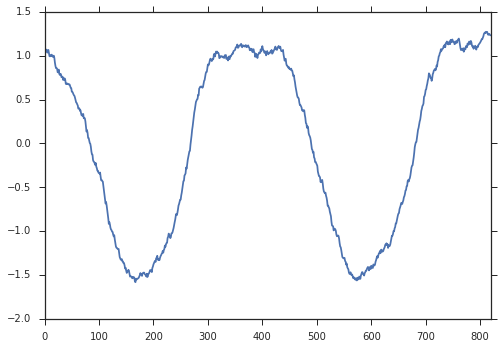

In [22]:
plt.plot(X[500,:])
plt.xlim(0,X.shape[1])
plt.show()

# 3. Data Split

- RNN의 경우 label을 달리해주어야 함
- From
    - y = 1, ... , 4
- To
    - y = [1, 0, 0, 0], ... , [0, 0, 0, 1]
- sklearn.preprocessing에 OneHotEncoder 이용

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
# n_values sets number of classes 
ohe = OneHotEncoder(n_values = 3)
y_to_ohg = y.reshape(-1, 1)
ohe.fit(y_to_ohg) # X1 is defined in LabelEncoder part
y_ohe = ohe.transform(y_to_ohg) # transform gives scipy.sparse type output
y_ohe = y_ohe.toarray()

- Training data와 validation data로 나누기
- sklearn.cross_validation에 StratifiedKFold 이용

In [24]:
from sklearn.cross_validation import StratifiedKFold

In [25]:
skf = StratifiedKFold(y, n_folds=5)

In [16]:
train_indices, valid_indices = next(iter(skf))
X_train, y_train = X[train_indices, :], y_ohe[train_indices]
X_valid, y_valid = X[valid_indices, :], y_ohe[valid_indices]

# 4. Classification

## 4.1. Recurrent Neural Network

- Import tensorflow

In [17]:
import tensorflow as tf

- Define Variable

In [18]:
'''
batch size
learning rate
n_iter
flag
등 학습과정에서 필요할 variable 정의
'''
learning_rate = 0.5
n_iter = 5000
flag = 500

- Define Network Size

    - input data의 shape확인

In [20]:
'''
total length
input sequence
input steps
hidden layer 개수
등 네트워크를 구성하는데 직접적인 영향을 주는 variable정의
'''
total_length = 820
n_steps = 10
n_input_sequence = int(total_length//n_steps)
n_hidden = 30
n_classes = 3

- Define Weights

In [21]:
'''
Network 안에 들어갈 weigth, biases 정의
'''

weights = {
    'out' : tf.Variable(tf.random_normal([n_hidden, n_classes], stddev = 0.1))
}

biases = {
    'out' : tf.Variable(tf.random_normal([n_classes], stddev = 0.1))
}

- Define Network

In [22]:
def RNN(x, weights, biases, n_input_sequence, n_steps):
    '''
    before transpose,  x shape is [batch_size, n_step, n_input]
    after transpose, [n_step, batch_size, n_input]
    '''
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input_sequence])

    #split
    '''
    0 : row를 의미
    n_stpes : 나눌 개수
    x : 대상
    결과 : x가 n_steps개수로 split됨
    '''
    x = tf.split(0, n_steps, x)

    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias =5.0, state_is_tuple= True)
    outputs, states = tf.nn.rnn(lstm_cell, x, dtype = tf.float32)

    return tf.matmul(outputs[-1], weights['out']) + biases['out'], outputs

- Define Cost

In [23]:
x = tf.placeholder(tf.float32, [None, n_steps, n_input_sequence])
y = tf.placeholder(tf.float32, [None, n_classes])

RNN_result, state_result = RNN(x, weights, biases, n_input_sequence, n_steps)

cost = tf.reduce_mean(tf.square(RNN_result - y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

- Optimize

In [24]:
init = tf.initialize_all_variables()
sess = tf.Session()

sess.run(init)

for epoch in range(n_iter):

    sess.run(optimizer, feed_dict={x: X_train_reshape,  y: y_train})
    c = sess.run(cost, feed_dict={x: X_train_reshape,  y: y_train})
    if epoch % flag == 0:
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.3007587790489197
Iter : 500
Cost : 0.02891690842807293
Iter : 1000
Cost : 0.013557976111769676
Iter : 1500
Cost : 0.007815263234078884
Iter : 2000
Cost : 0.004665090702474117
Iter : 2500
Cost : 0.0029991476330906153
Iter : 3000
Cost : 0.002143972087651491
Iter : 3500
Cost : 0.0016451177652925253
Iter : 4000
Cost : 0.0013077271869406104
Iter : 4500
Cost : 0.001058275462128222


- Validatioin set으로 성능확인

In [25]:
X_valid_reshape = np.reshape(X_valid, [-1, n_steps, n_input_sequence])
pred = sess.run(RNN_result, feed_dict={x:X_valid_reshape})
accuracy = np.mean(np.equal(np.argmax(pred, 1), np.argmax(y_valid, 1)))
print('Accuracy = {:.4f}'.format(accuracy))

Accuracy = 0.9533


In [26]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>